In [ ]:
#!pip install google-cloud-bigquery #Only run once

Importing all packages for models and querieng

In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split

Authenticating and Connecting to the Google Querey database

In [ ]:
#Authenticate and Connect to the Data

os.environ['USE_AUTH_EPHEM'] = '0'  #Bypass the special permissions error from before

# Authenticate to Google Cloud
auth.authenticate_user()
project_id = 'ticketcity-tcg' # Replace with your project ID
client = bigquery.Client(project=project_id) # This line is added to create the client object

project_id = 'ticketcity-tcg'

# Construct a BigQuery client object.
client = bigquery.Client(project=project_id)

# Replace with your project ID and dataset/table names.
# dataset_id = ''
table_id = 'data-ticketcity.TC_Data.InventoryStream'

Authenticated


This SQL query extracts recent event-level ticketing data from the TicketCity dataset, focusing on events reported in the last seven days. It includes detailed information on event timing, location, sales performance, revenue, and ticket pricing, as well as metadata about the main performer. The query also calculates how many days in advance tickets were purchased, enabling analysis of consumer behavior and event demand trends.

In [ ]:
# Create a SQL query string for our data.
query = f"""
SELECT
    e.PID AS EventID,
    e.Name AS EventName,
    -- Convert "MM/DD/YY hh:mm AM/PM" format to proper TIMESTAMP
    TIMESTAMP(PARSE_TIMESTAMP("%m/%d/%y %I:%M %p", e.Date)) AS EventDateTime,
    e.Venue,
    e.City,
    e.State,
    e.Event_Type,
    e.Category,
    e.Orders,
    e.Quantity as TotalEventTickets,
    e.Avg_Order_Size as Order_Price,
    e.Revenue,
    ROUND(SAFE_DIVIDE(e.Revenue, e.Quantity), 2) AS Ticket_Price,  -- New column: Ticket Price
    e.Report_Date as Date_Of_Purchase,
    DATE_DIFF(
       DATE(TIMESTAMP(PARSE_TIMESTAMP("%m/%d/%y %I:%M %p", e.Date))),
       e.Report_Date,
       DAY
    ) AS DaysBetweenPurchaseAndEvent,
    pe.Performer_Name,
    ep.Master
FROM `data-ticketcity.TFS_Reports.75_Event_Daily` e
LEFT JOIN `data-ticketcity.VividIntake.EventPerformers` ep
    ON e.PID = ep.Event_ID
    AND TIMESTAMP_TRUNC(ep._PARTITIONTIME, DAY) = TIMESTAMP("2025-03-01")
LEFT JOIN `data-ticketcity.VividIntake.Performers` pe
    ON ep.Performer_ID = pe.Performer_ID
    AND TIMESTAMP_TRUNC(pe._PARTITIONTIME, DAY) = TIMESTAMP("2025-03-01")
WHERE
    e.Report_Date >= DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY)
    AND e.PID IS NOT NULL
    AND e.Name IS NOT NULL
    AND e.Date IS NOT NULL
    AND e.Revenue IS NOT NULL
    AND e.Avg_Order_Size IS NOT NULL
    AND e.Orders IS NOT NULL
    AND e.Quantity IS NOT NULL
    AND e.Category != 'Parking'
    AND (ep.Master IS NULL OR ep.Master = TRUE)
ORDER BY e.Report_Date ASC;
"""

This takes a previously a previously run BigQuery SQL query, converts them into a pandas DataFrame, and performs several data cleaning steps. It removes outliers from all numerical columns using the Interquartile Range (IQR) method, filters out records where the ticket purchase date falls on a Tuesday, and fills missing performer names with the event name. The cleaned data is saved to two CSV files: one after removing Tuesdays (filtered_transformed_data.csv) and one final version (cleaned_query_results.csv) with missing performer names handled.

In [ ]:
# Run the query
query_job = client.query(query)
results = query_job.result()  # Fetch results again

# data = []
# for row in results:
  # data.append(dict(row))

# Convert query results into a list of dictionaries
data = [dict(row) for row in results]

# Convert the list into a DataFrame
df = pd.DataFrame(data)

numerical_cols = df.select_dtypes(include=[np.number]).columns

# Remove outliers using the Interquartile Range (IQR) method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))]

# Apply outlier removal to all numerical columns
for col in numerical_cols:
    df = remove_outliers(df, col)

#Remove the Tuesday's from the data (from what Jim said)
df['Date_Of_Purchase'] = pd.to_datetime(df['Date_Of_Purchase'])
df_filtered = df[df['Date_Of_Purchase'].dt.day_name() != 'Tuesday']
df_filtered.to_csv("filtered_transformed_data.csv", index=False)

#Removing null
df['Performer_Name'] = df['Performer_Name'].fillna(df['EventName'])

# Save cleaned data to CSV
df.to_csv('cleaned_query_results.csv', index=False)

print("Cleaned query results saved to cleaned_query_results.csv")


Cleaned query results saved to cleaned_query_results.csv


This code block loads the previously cleaned event data from cleaned_query_results.csv and applies label encoding to selected categorical columns such as EventName, Venue, City, Event_Type, and Performer_Name. For each column, it creates a new encoded version and stores the mappings of original categories to numeric values in a dictionary. The transformed dataset is saved to transformed_data.csv, and a reference file with all encoding mappings is saved separately as encoding_mappings.csv.

In [ ]:
# load the query results
df = pd.read_csv("cleaned_query_results.csv")

#print all columns in df
#print(df.columns)
#Index(['EventID', 'EventName', 'EventDateTime', 'Venue', 'City', 'State',
       #'Event_Type', 'Category', 'Orders', 'TotalEventTickets', 'Order_Price',
       #'Revenue', 'Ticket_Price', 'Date_Of_Purchase',
      # 'DaysBetweenPurchaseAndEvent', 'Performer_Name', 'Master'],
     # dtype='object')
columns_to_encode = ['EventName', 'Venue','City', 'State', 'Event_Type', 'Category', 'Performer_Name'] #only decided to encode these ones

label_encoders = {}
for col in columns_to_encode:
    label_encoder_instance = LabelEncoder()
    df[f"{col}_encoded"] = label_encoder_instance.fit_transform(df[col])  # create new encoded column
    label_encoders[col] = dict(zip(label_encoder_instance.classes_, label_encoder_instance.transform(label_encoder_instance.classes_)))  # store mappings using the classes_ & numerical values
df.to_csv("transformed_data.csv", index=False)
print("Transformed data results saved to transformed_data.csv")

# save encoding mappings as reference if needed
encoding_df = pd.DataFrame([
    {'Column': col, 'Category': cat, 'Encoded Value': val}
    for col, mapping in label_encoders.items()
    for cat, val in mapping.items()
])
encoding_df.to_csv("encoding_mappings.csv", index=False)
print("Encoding mappings saved to encoding_mappings.csv")

Transformed data results saved to transformed_data.csv
Encoding mappings saved to encoding_mappings.csv


This code block loads the transformed event dataset (transformed_data.csv), defines the feature matrix X by dropping non-informative or redundant columns, and sets y as the target variable representing ticket price. It then performs a train-test split (80% training, 20% testing) to prepare the data for modeling and saves each split (X_train, X_test, y_train, y_test) to separate CSV files for easy access in future modeling steps.

In [ ]:
# Load dataset
df = pd.read_csv("transformed_data.csv")
# Define features (X) and target variable (y)
X = df.drop(columns=['EventName', 'Venue','City', 'State', 'Event_Type', 'Category', 'Performer_Name','EventDateTime',
                     'Master', 'Date_Of_Purchase', 'EventID', 'Revenue', 'Ticket_Price', 'Order_Price'])  # Features variable
y = df["Ticket_Price"]  # Target variable

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Save split data if needed
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Data successfully split and saved.")


Data successfully split and saved.


Initializing the XGBRegressor model, training it, and making a prediction. XGBRegressor is a gradient boosting algorithm from the XGBoost library, designed for efficient and accurate prediction of continuous numerical values. It combines ensemble learning with advanced regularization techniques to reduce overfitting and improve model performance.

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, enable_categorical=True)

# Train
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

This code block determines the feature importance and creates a graph to visualize.

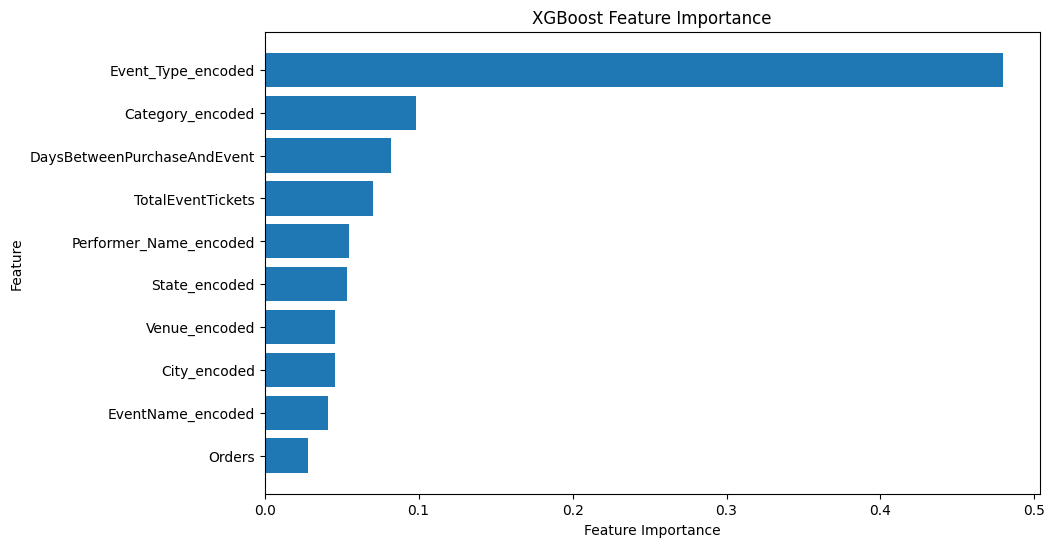

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = xgb_model.feature_importances_
sorted_idx = feature_importance.argsort()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()

Example testing for a G-Eazy event where we provided variables in order to predict pricing of certain event. It takes a sample event dictionary, encodes all categorical fields using previously saved label mappings (encoding_mappings.csv), constructs a properly formatted DataFrame with the expected model features, and then predicts the ticket price, printing the result.

In [ ]:
#Example event prediction
example_event = {
    "Orders": 1,
    "TotalEventTickets": 2,
    "DaysBetweenPurchaseAndEvent": 42,
    "EventName": "G-Eazy",
    "Venue": "Revel Entertainment Center",
    "City": "Albuquerque",
    "State": "NM",
    "Event_Type": "Concert",
    "Category": "Rap/Hip Hop",
    "Performer_Name": "G-Eazy"
}

encoding_df = pd.read_csv("encoding_mappings.csv")

#All encoders
label_encoders = {}
for col in encoding_df["Column"].unique():
    sub_df = encoding_df[encoding_df["Column"] == col]
    label_encoders[col] = dict(zip(sub_df["Category"], sub_df["Encoded Value"]))

#Encode categorical columns
for col in ['EventName', 'Venue', 'City', 'State', 'Event_Type', 'Category', 'Performer_Name']:
    if example_event[col] in label_encoders[col]:
        example_event[f"{col}_encoded"] = label_encoders[col][example_event[col]]
    else:
        example_event[f"{col}_encoded"] = -1

model_features = ['Orders', 'TotalEventTickets', 'DaysBetweenPurchaseAndEvent',
                  'EventName_encoded', 'Venue_encoded', 'City_encoded', 'State_encoded',
                  'Event_Type_encoded', 'Category_encoded', 'Performer_Name_encoded']

example_input_df = pd.DataFrame([example_event])[model_features]

#Predict ticket price
predicted_price = xgb_model.predict(example_input_df)[0]
print(f"Predicted Ticket Price: ${predicted_price:.2f}")



Predicted Ticket Price: $96.90
